# TensorFlow Lite model optimization

TensorFlow Lite에서는 edge device에서 모델의 inference를 효율적으로 하기 위한 방법인 quantization과 pruning을 이용할 수 있는 toolkit을 제공하고 있습니다. 이번 실습에서는 해당 toolkit을 이용해 볼 것입니다.

더 자세한 내용은 document를 참고 해주세요.
- https://www.tensorflow.org/model_optimization/guide
- https://www.tensorflow.org/lite/performance/model_optimization
- TFLite https://www.tensorflow.org/lite/guide

## 0. What is TFLite?

TensorFlow Lite는 TensorFlow로 학습된 모델을 tflite이라는 포맷으로 바꿔 줌으로써 모바일 장치, 임베디드 장치 등의 가벼운 장치에서 모델을 inference 할 수 있게 해주는 플랫폼 이다.

<img src="https://user-images.githubusercontent.com/37704174/115159215-fccd0800-a0cc-11eb-817b-645f96c76966.png" width="400" height="400"/>  


TensorFlow는 모델을 파일로 저장할 때는 [Protocol Buffer](https://developers.google.com/protocol-buffers)라는 포맷으로 저장을 하고, TensorFlow Lite의 모델은 [FlatBuffer](https://google.github.io/flatbuffers/)라는 포맷으로 저장을 합니다. 두 포맷의 가장 큰 차이점은 FlatBuffer는 serialized 파일을 추가적인 메모리 할당 없이 deserialize를 할 수 있기 때문에 빠르게 파일에 있는 데이터에 접근할 수 있다.


TFLite 모델로 변환을 할 때, quantization과 pruning 등의 optimization을 할 수 있는데, 이 때의 장점은 다음과 같다.

- Size reduction
  - smaller storage size, smaler download size, less memory usage
- Latency reduction
  - computation을 줄여 줌으로써 inference에 걸리는 시간 감소
- Accelerator compatibility
  - Edge TPU와 같이 특정 hardware는 각각의 quantization 요구 사항을 만족해야 함

tensorflow 최신 버전 설치

In [1]:
!pip uninstall -y tensorflow
!pip install tf-nightly

Found existing installation: tensorflow 2.1.0
Uninstalling tensorflow-2.1.0:
  Successfully uninstalled tensorflow-2.1.0
     |████████████████████████████████| 456.8 MB 56 kB/s s eta 0:00:01   |▋                               | 9.4 MB 10.6 MB/s eta 0:00:43     |▊                               | 10.9 MB 10.6 MB/s eta 0:00:42     |█▏                              | 16.3 MB 10.6 MB/s eta 0:00:42     |███▏                            | 45.8 MB 21.7 MB/s eta 0:00:19     |███▉                            | 55.0 MB 21.7 MB/s eta 0:00:19     |██████▏                         | 88.7 MB 8.6 MB/s eta 0:00:44     |██████▎                         | 89.6 MB 8.6 MB/s eta 0:00:43     |███████▎                        | 104.3 MB 27.2 MB/s eta 0:00:13     |█████████▎                      | 132.8 MB 13.8 MB/s eta 0:00:24     |████████████▍                   | 177.5 MB 20.5 MB/s eta 0:00:14     |██████████████                  | 200.4 MB 18.5 MB/s eta 0:00:14     |██████████████▎                 | 204.4 MB 18

  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: six
    Found existing installation: six 1.14.0
    Uninstalling six-1.14.0:
      Successfully uninstalled six-1.14.0
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.9.0
    Uninstalling absl-py-0.9.0:
      Successfully uninstalled absl-py-0.9.0
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 0+untagged.56.g2664021.dirty
    Uninstalling opt-einsum-0+untagged.56.g2664021.dirty:
      Successfully uninstalled opt-e

kernel restart

In [2]:
import os
import numpy as np
import zipfile
import tempfile
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
tf.__version__

'2.6.0-dev20210430'

## 1. Quantization
### 1-1. [Post-training quantization](https://blog.tensorflow.org/2019/06/tensorflow-integer-quantization.html)

post-training quantization은 학습을 한 다음에 quantization을 하는 방법이다. quantization aware training보다는 accuracy가 좀 떨어질 수 있지만, 학습된 모델을 가져와서 쉽게 쓸 수 있다. tensorflow에서 다음과 같은 방법들을 제공하고 있다.


<img src="https://user-images.githubusercontent.com/37704174/114367164-2232b100-9bb7-11eb-81e7-b9b8dec09de5.png" width="700" height="700"/>  
- dynamic range quantization: weight은 8 bit integer로 저장. inference 시에는 8bit float로 바뀜. activation은 range에 따라서(dynamic) 8 bit float으로 저장


나중에 Edge TPU가 있는 Coral board를 사용할 것이기 때문에, post-training integer quantization을 다뤄 볼 것이다.


먼저 quantizaion을 할 간단한 모델을 학습한다.

In [4]:
# Load MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the input image
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture


model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=False),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,  
  epochs=4,
  validation_data=(test_images, test_labels)
)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/4
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4582 - accuracy: 0.8366 - val_loss: 0.3499 - val_accuracy: 0.8768
Epoch 2/4
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3166 - accuracy: 0.8874 - val_loss: 0.3116 - val_accuracy: 0.8892
Epoch 3/4
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2839 - accuracy: 0.8991 - val_loss: 0.2908 - val_accuracy: 0.8947
Epoch 4/4
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2601 - accuracy: 0.9058 - val_loss: 0.2794 - val_accuracy: 0.8987


학습된 모델을 변환하기 위해서는 [TensorFlow Lite converter](https://www.tensorflow.org/lite/convert)라는 것을 이용해야 합니다. 이것은 TensorFlow 모델을 TensorFlow Lite 모델로 바꿔 줍니다.

다음과 같이 tflite 모델로 변환할 수 있습니다.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# 이 사이에 많은 옵션 추가 가능
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd7dien96/assets


변환할 때 아무런 옵션을 주지 않았으므로 이 모델은 단순히 32-bit float tflite 모델입니다.

### Post-training integer quantization


<img src="https://user-images.githubusercontent.com/37704174/114906428-f9c7e280-9e54-11eb-9038-9854d5c8d741.png" width="700" height="700"/>  
<img src="https://user-images.githubusercontent.com/37704174/114907026-9e4a2480-9e55-11eb-980f-55999688c260.png" width="500" height="500"/>  


다음 셀을 실행하면 quantization이 완료 된다.

In [6]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 옵션들
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen # 함수로 설정해야 한다.
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # 이 모델은 integer 연산만 할 것
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8
# 옵션 끝

post_quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1mnhdxwp/assets


INFO:tensorflow:Assets written to: /tmp/tmp1mnhdxwp/assets


evaluate을 위한 helper function이다. input type을 integer로 했으므로, quantize를 한 다음에 inference를 한다.

In [8]:
def evaluate_model(interpreter):
    global test_images
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if (i+1) % 1000 == 0:
              print('Evaluated on {n} results so far.'.format(n=i+1))

        # quantize input
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point # test image를 integer로 변환

        # Pre-processing: add batch dimension
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print()
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy, output

tflite 모델로 inference를 하려면 [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)를 이용한다. `model_content` 대신에 `model_path`를 이용하면 tflite 파일을 불러올 수도 있다.  
inference를 하기 위해서는  
interpreter 생성 &#8594; `allocate_tensor` &#8594; `set_tensor` &#8594; `invoke` 순으로 실행한다.  
지금 코드는 inference 할 때 image를 하나씩 처리하는데, batch 단위로 처리하려면 `resize_tensor_input`을 이용한다.

In [9]:
# 32bit float tflite 모델로 interpreter 만듦
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# inference 할 때 input batch 수를 설정하는 법
# input_details = interpreter.get_input_details()[0]
# interpreter.resize_tensor_input(input_details["index"], [10, 28, 28]) # <-- 추가

interpreter.allocate_tensors()
tflite_test_accuracy, _ = evaluate_model(interpreter)

# 8bit integer tflite
post_quant_interpreter = tf.lite.Interpreter(model_content=post_quant_tflite_model)
post_quant_interpreter.allocate_tensors()
post_quant_tflite_test_accuracy, output = evaluate_model(post_quant_interpreter)

Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.

Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.



`get_input_details`, `get_output_details`를 통해 input과 output의 type 및 quantization 정보를 알 수 있다.

In [10]:
post_quant_interpreter.get_input_details()

[{'name': 'input_1',
  'index': 0,
  'shape': array([ 1, 28, 28], dtype=int32),
  'shape_signature': array([-1, 28, 28], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [11]:
post_quant_interpreter.get_output_details()

[{'name': 'Identity',
  'index': 24,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

실제로 inference output이 정수임을 확인할 수 있다.

In [12]:
output()

array([[  0,   0,   1,   0,   0, 163,   0,  65,  26,   1]], dtype=uint8)

float 32 모델과 accuracy를 비교해 보자.

In [13]:
print('TFLite test accuracy:', tflite_test_accuracy)
print('Post-training Quant TFLite test_accuracy:', post_quant_tflite_test_accuracy)

TFLite test accuracy: 0.8987
Post-training Quant TFLite test_accuracy: 0.8962


모델을 파일로 저장해서 실제로 모델 크기가 줄어들었는지 확인해 보자.

In [14]:
# create temp file
_, tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_tflite_file = tempfile.mkstemp('.tflite')


with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

with open(post_quant_tflite_file, 'wb') as f:
    f.write(post_quant_tflite_model)


print("Float model in Mb:", os.path.getsize(tflite_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(post_quant_tflite_file) / float(2**20))

Float model in Mb: 0.08170700073242188
Quantized model in Mb: 0.02512359619140625


### 실습: TensorFlow에서 제공하는 pretrain model 가져와서 post-training quantization 해보기

TensorFlow에서는 여러 pretrained model을 제공한다. 아무거나 하나 가져와서 post-training quantization을 해보자.  

In [15]:
# pretrain 모델 import 하기.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display

다음의 test image를 이용할 것이다. quantization을 할 때, representative data로는 이 이미지 하나만 이용해도 된다.

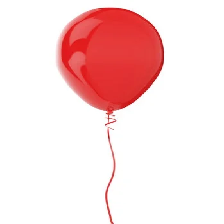

In [16]:
url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # 각 모델을 학습할 때 preprocess했던 방법을 사용 - ResNet의 경우 zero centering etc 수행

evaluate 할 때는 다음 함수를 이용

In [17]:
def evaluate_model_practice(interpreter, test_images):
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=(i+1)))

        # quantize input
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # Pre-processing: add batch dimension
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        preds = interpreter.tensor(output_index)
        preds = np.expand_dims(preds()[0], axis=0)

    return preds

코드 작성

In [24]:
# 1. import한 pretrain 모델 가져오기
imagenet = ResNet50(weights='imagenet')

preds = imagenet.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02782093', 'balloon', 0.94828665), ('n04023962', 'punching_bag', 0.034170937), ('n03942813', 'ping-pong_ball', 0.0027104064)]


In [25]:
# 크기 비교를 위한 32bit float tflite 모델 생성
converter = tf.lite.TFLiteConverter.from_keras_model(imagenet)
imagenet_tflite = converter.convert()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpqpxsu64q/assets


INFO:tensorflow:Assets written to: /tmp/tmpqpxsu64q/assets


In [26]:
# 2. full integer post-training quantization
import numpy as np

def representative_data_gen():
    yield [x] # test 할 이미지 1개만 사용

converter = tf.lite.TFLiteConverter.from_keras_model(imagenet)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# ensure that if any ops can't be quantized, the converter throws an error.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8

post_quant_imagenet_tflite = converter.convert()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpa6v1x9sy/assets


INFO:tensorflow:Assets written to: /tmp/tmpa6v1x9sy/assets


In [27]:
# 3. make interpreter and do inference
# 32bit float tflite 모델로 interpreter 만듦
post_quant_imagenet_interpreter = tf.lite.Interpreter(model_content=post_quant_imagenet_tflite)
post_quant_imagenet_interpreter.allocate_tensors()

preds = evaluate_model_practice(post_quant_imagenet_interpreter, x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Evaluated on 1 results so far.
Predicted: [('n02782093', 'balloon', 240), ('n04023962', 'punching_bag', 11), ('n03942813', 'ping-pong_ball', 1)]


크기 비교

In [28]:
# measure sizes of models.
_, imagenet_tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_imagenet_tflite_file = tempfile.mkstemp('.tflite')


with open(imagenet_tflite_file, 'wb') as f:
    f.write(imagenet_tflite)

with open(post_quant_imagenet_tflite_file, 'wb') as f:
    f.write(post_quant_imagenet_tflite)


print("Float model in Mb:", os.path.getsize(imagenet_tflite_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(post_quant_imagenet_tflite_file) / float(2**20))

Float model in Mb: 97.43085861206055
Quantized model in Mb: 25.079750061035156


### 1-2. [Quantization Aware Training(QAT)](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)

수업 시간에 배웠 듯이 QAT는 나중에 quantization을 할 것이라는 것을 가정하고 학습하는 것이다. scratch부터 학습해도 되지만, 이미 학습된 모델을 fine tuning 하는 것이 좋다고 한다.

In [29]:
!pip install -q tensorflow-model-optimization

In [30]:
import tensorflow_model_optimization as tfmot

### Quantize whole model

Edge TPU와 같이 fully quantized 모델이 필요한 경우에는 전체 모델에 대해 QAT를 한다.

위에서 학습한 float32모델로 QAT를 해볼 것이다.`quantize_model`함수를 이용한다.

In [31]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28)            3         
_________________________________________________________________
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 28, 28, 16)        195       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 16)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 14, 14, 32)        4707      
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 32)          1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 1568)              1

layer에 quant가 붙은 것을 확인할 수 있다. 그 다음으로는, data의 일부를 이용해서 fine tuning 한다.

In [32]:
# data 일부를 이용해서 fine tuning
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

quant_aware_model.fit(train_images_subset, train_labels_subset, # qat 진행
                  batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 2s 435ms/step - loss: 0.2096 - accuracy: 0.9256 - val_loss: 0.2689 - val_accuracy: 0.9100


아직 quantization을 하지 않았으므로 weight은 실수이다.

In [33]:
quant_aware_model.layers[2].get_weights()

[array([-7.7812816e-03, -1.2126947e-02,  9.7242072e-03,  2.4985732e-03,
         2.2446243e-02, -7.8753596e-03,  6.2441267e-03, -4.4326237e-03,
         2.1035101e-02, -2.2471838e-02,  2.1389256e-01,  1.0915109e-02,
        -1.6672490e-04, -7.3085800e-03, -1.1691596e-02,  1.5000826e-02],
       dtype=float32),
 array([[[[-0.00525647, -0.29738104, -0.29413444,  0.21692048,
           -0.15882193, -0.15578982, -0.22276993,  0.04558412,
           -0.23259796,  0.17230383,  0.11304303, -0.2827086 ,
            0.16056079, -0.02098618,  0.04581424,  0.08820706]],
 
         [[ 0.08438446, -0.07145761,  0.16581048,  0.3423589 ,
           -0.5456619 ,  0.24957405,  0.1933133 ,  0.09705455,
            0.43871638,  0.38245338,  0.26191664, -0.14987879,
            0.22836232, -0.08126036, -0.12456531, -0.35000733]],
 
         [[-0.1544532 ,  0.20232083,  0.1441259 ,  0.10859156,
           -0.14982082,  0.08728001,  0.16210154,  0.26284206,
           -0.1922192 ,  0.0329748 ,  0.2680842 , 

실수 weight이므로 QAT를 한다고 해서 accuracy가 떨어지지 않는다.

In [34]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, quant_aware_model_accuracy = quant_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('QAT test accuracy:', quant_aware_model_accuracy)

Baseline test accuracy: 0.8986999988555908
QAT test accuracy: 0.8996999859809875


이제 QAT로 학습한 모델을 quantization 해보자. post-training quantization과 비슷하게 TFLiteConverter를 이용하면 된다.

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8


QAT_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpm59v_ce6/assets


INFO:tensorflow:Assets written to: /tmp/tmpm59v_ce6/assets


quantization을 해도 accuracy가 떨어지지 않는 것을 알 수 있다.

In [36]:
QAT_interpreter = tf.lite.Interpreter(model_content=QAT_tflite_model)
QAT_interpreter.allocate_tensors()

QAT_test_accuracy, output = evaluate_model(QAT_interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Post-training Quantized test accuracy:', post_quant_tflite_test_accuracy)
print('Quantized QAT test accuracy:', QAT_test_accuracy)

Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.

Baseline test accuracy: 0.8986999988555908
Post-training Quantized test accuracy: 0.8962
Quantized QAT test accuracy: 0.9003


마찬가지로 크기가 1/4로 줄어든 것을 알 수 있다.

In [37]:
# create temp file
_, QAT_tflite_file = tempfile.mkstemp('.tflite')

with open(QAT_tflite_file, 'wb') as f:
    f.write(QAT_tflite_model)

print("Float tflite model in Mb:", os.path.getsize(tflite_file) / float(2**20))
print("Quantized QAT model in Mb:", os.path.getsize(QAT_tflite_file) / float(2**20))

Float tflite model in Mb: 0.08170700073242188
Quantized QAT model in Mb: 0.0255889892578125


### Quantize some layers

Edge TPU 등 특별한 하드웨어가 아닌 경우에는 선택적으로 layer를 quantization할 수도 있다.

**Tips for better accuracy**
* from scratch보다는 fine tuning
* 뒤쪽 layer를 quantization 하기
* 특별히 중요한 layer는 quantization 피하기


`quantize_annotate_layer` 함수를 이용해서 특정 layer를 quantization할 것이라고 표시한다.

In [38]:
model.layers[-1].name

'dense'

In [39]:
# Helper Function
def apply_quantization_to_dense(layer): # layer를 input으로 받아서 어떤 layer에만 quant 할거라고 표시하는 것
    # if isinstance(layer, tf.keras.layers.Dense)
    if layer.name == 'dense':
        return tfmot.quantization.keras.quantize_annotate_layer(layer) # quant
    else:
        return layer # 그대로

`clone_model` 함수와 helper function을 이용해서 annotated model을 만들고, `quantize_apply`함수를 이용해서 QAT를 위한 모델을 만들면 된다.

In [40]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 10)                1

만약 fine tuning이 아니라 처음부터 모델을 만드는 것이면 다음과 같이 모델을 만들면 된다.

**Sequential example**

In [41]:
annotated_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10)) # 직접 설정
])
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2028)              0         
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                20295     
Total params: 20,415
Trainable params: 20,410
Non-trainable params: 5
_________________________________________________________________


**Functional example**

In [42]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(inputs)
x = tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))(x) # 직접 설정
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

annotated_model = tf.keras.Model(inputs=inputs, outputs=outputs)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 26, 26, 12)        147       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20290     
Total params: 20,437
Trainable params: 20,410
Non-trainable params: 27
________________________________________________________

## 2. [Pruning](https://blog.tensorflow.org/2019/05/tf-model-optimization-toolkit-pruning-API.html)

pruning은 불필요한(0에 가까운) weight을 0으로 만들어 없애면서 optimize를 한다.

`tfmot.sparsity.keras.prune_low_magnitude`을 이용해서 모델을 만든다. 이 때, pruning 방식인 `tfmot.sparsity.keras.PolynomialDecay` 을 parameter로 넘겨준다. 다음과 같은 hyperparemeter가 있다.
* `initial_sparsity`: pruning을 시작할 때의 sparsity를 몇으로 할 지
* `final_sparsity`: pruning을 끝낼 때의 sparsity를 몇으로 할 지
* `begin_step`: pruning을 언제부터 진행할 지 (batch 단위의 step)
* `end_step`: pruning을 언제 끝낼 지

pruning을 하기 전에 baseline model을 저장하겠다. (크기 비교시 사용)

In [43]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmp6nawnhkh.h5


In [44]:
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2

num_images = train_images.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs # 총 step 개수

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_for_pruning.summary()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2193: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_reshape  (None, 28, 28, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 16)        306       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 16)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 32)        9250      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 32)          1         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 1568)              1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 10)                3

`fit`을 할 때, `tfmot.sparsity.keras.UpdatePruningStep`을 callback으로 불러야 한다

In [45]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(), # 필요!
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, 
                  epochs=epochs,
                  callbacks=callbacks)

Epoch 1/2
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


469/469 [==============================] - 13s 23ms/step - loss: 0.2850 - accuracy: 0.8995
Epoch 2/2
469/469 [==============================] - 11s 23ms/step - loss: 0.2993 - accuracy: 0.8931


baseline 모델과 accuracy를 비교해 보자.

In [46]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.8986999988555908
Pruned test accuracy: 0.8884999752044678


pruned model의 크기가 줄어들었는 지 확인해 보자.

위에 summary를 보면 pruning을 하기 위해 non-trainable parameter가 생긴 것을 알 수 있다. `tfmot.sparsity.keras.strip_pruning`을 이용해서 pruning에 사용한 variable을 제거해 준다.

In [47]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning) # pruning 시 늘어난 non-trainable parameter를 없애기 위해

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpvbhaq1f9.h5


tflite 으로 저장

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmp5bh73zqf/assets


INFO:tensorflow:Assets written to: /tmp/tmp5bh73zqf/assets


Saved pruned TFLite model to: /tmp/tmppm_i1v8y.tflite


pruning을 해도 weight matrix의 크기는 그대로이다. 하지만 matrix의 값이 대부분 0이기 때문에 감소된 크기를 확인하려면 실제로 zip파일 등으로 압축하는 과정을 거쳐야 한다.

In [49]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [50]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 78962.00 bytes
Size of gzipped pruned Keras model: 26548.00 bytes
Size of gzipped pruned TFlite model: 25355.00 bytes


### Combine pruning and quantization
pruning을 한 다음에 post-training quantization까지 하면 크기를 더 줄일 수 있다.

In [51]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmpkec0cvbb/assets


INFO:tensorflow:Assets written to: /tmp/tmpkec0cvbb/assets


Saved quantized and pruned TFLite model to: /tmp/tmptxymmuxl.tflite
Size of gzipped baseline Keras model: 78962.00 bytes
Size of gzipped pruned and quantized TFlite model: 9494.00 bytes


baseline 과 accuracy를 비교해 보자

In [52]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy, _ = evaluate_model(interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.

Baseline test accuracy: 0.8986999988555908
Pruned and quantized TFLite test_accuracy: 0.8892


QAT와 비슷하게, pruning도 layer를 선택적으로 pruning 할 수 있다. 이 부분은 [document](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)를 참고

# [ONNX](https://github.com/onnx/onnx)

학습된 tensorflow 모델을 이용해서 tflite 모델을 만들고 싶은데, tensorflow 모델은 없고 pytorch 모델만 있다면...? 이럴 때 사용하는 것이 ONNX이다. ONNX는 서로다른 deep learning framework에서 모델을 사용하고 싶을 때, 모델을 원하는 framework로 변환해 주는 기능을 제공한다. 
  
즉, ONNX를 이용해서 pytorch 모델을 tensorflow 모델로 바꾼 다음, tensorflow lite 모델을 만들어 주면 된다.
예시 코드를 ONNX.ipynb로 올려 두었다.
  
* 서치를 해보니 모든 모델을 완벽하게 바꿔주는 것은 아니여서 (accuracy 감소 및 변환이 안되는 operation 등이 있을 수 있다), 처음부터 학습해야 하는 경우에는 pytorch 코드를 tensorflow 코드로 구현해서 모델을 학습하는게 좋고, 그게 잘 안되거나 pretrained pytorch 모델을 꼭 써야하는 경우에 이용하면 좋을 것 같다.
* 또한 pytorch 버전, tensorflow 버전, onnx 버전 등 버전에 영향을 많이 받는 것 같아서 실제로 본인이 원하는 모델을 바꾸려면 많은 시행착오가 필요해 보임

# HW5

### Due: 21.05.03 15:29

이번 과제는 8-bit integer quantization을 했을 때, 어떤 식으로 계산이 이루어지는 지 source code 분석을 통해 알아보는 과제이다.

먼저, TFLite에서 지원하는 operation에 대한 부분은 다음 파일에 있다.
* [register.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/register.cc)

ReLU를 예시로 들면, ReLU는 `Register_RELU()` 함수가 있다.  
<img src="https://user-images.githubusercontent.com/37704174/114957599-526e9e00-9e9c-11eb-928a-17a9dda8b050.PNG" width="500" height="500"/> 

이 함수는 다음 파일에 구현이 되어있다.

<img src="https://user-images.githubusercontent.com/37704174/114957607-54d0f800-9e9c-11eb-9be3-1aa960f0d925.PNG" width="500" height="500"/>  

* [activations.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/activations.cc)

4가지 함수가 있다.
* Init: new parameter allocation
* Free: free allocated parameters
* Prepare: fill the parameter values
* **Eval**: Run computation of operation using filled parameters

즉, 어떻게 계산이 이루어 지는 지를 보려면 `ReluEval`을 보면 될 것이다.


보고서에 포함되어야 하는 내용은 다음과 같다.
1. float min, float max로부터 quantization parameter (scale, zero point)가 어떻게 계산 되는 지
  * [quantization_utils.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/tools/optimize/quantization_utils.cc)
    * `GetAsymmetricQuantizationParams`, `GetSymmetricQuantizationParams`
2. 3가지 layer에 대해 quantization parameter를 이용해서 어떤 식으로 integer-only arithmetic을 수행하는 지
    - **ReLU**, **logistic**
      - [activations.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/activations.cc), [reference_ops.h](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/internal/reference/reference_ops.h), [optimized_ops.h](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/internal/optimized/optimized_ops.h)
    - **Fully connected**
      - [fully_connected.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/fully_connected.cc), [fully_connected.h](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/kernels/internal/reference/integer_ops/fully_connected.h)
 

(함수의 정확한 동작, c/cpp의 정확한 문법을 알 필요는 없고, quantization과 computation에 대한 전반적인 흐름을 분석하면 된다.(어떤 함수를 부르게 되고, 어떤 정수 연산을 하게 되는지)

### 제출
pdf로 변환 후 **학번_이름_HW5.pdf** (ex. 2020_12345_김우중_HW5.pdf) etl에 제출